In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
filePath = '/content/gdrive/MyDrive/merged_reviews_finalDS.csv'

In [3]:
import pandas as pd

df = pd.read_csv(filePath, header=0)
print(df.head)
df.describe()


<bound method NDFrame.head of                                                      text  label
0       ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...      1
1       أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...      1
2       هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...      1
3       خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...      1
4       ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...      1
...                                                   ...    ...
164769  وهلأ لوين؟ ....سؤال اتمنى أن أطرحه في مصر اعتق...      1
164770  قراصنة الكاريبي بحس أنثوي ثلاثي الأبعاد بعد غي...      1
164771  قصة بسيطة ودراما واقعية إسلوب إخراجي يتسم بالح...      0
164772  بزوغ الفجر بتتويج دموي هكذا طل علينا فيلم ملحم...      1
164773  غزل البنات وأجمل معاني الحب عفوية وبساطة أجدها...      1

[164774 rows x 2 columns]>


,label
count,164774.000000
mean,0.213547
std,0.822813
min,-1.000000
25%,-1.000000
50%,0.000000
75%,1.000000
max,1.000000


In [4]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import re
import warnings

import nltk
nltk.download('stopwords')

stopwords_list = stopwords.words('arabic')
from nltk.corpus import stopwords
import re

def clean_text(text):
    # Remove non-Arabic characters
    arabic_text = re.sub(r'[^\u0600-\u06FF\s]', '', text)
    # Remove extra whitespaces
    cleaned_text = re.sub(r'\s+', ' ', arabic_text).strip()
    return cleaned_text
def cleaning_text(text):
    pat = [\
        (u'http[s]?://[a-zA-Z0-9_\-./~\?=%&]+', u''),               # remove links
        (r'[^\u0600-\u06FF\s]', u''),
        (u'www[a-zA-Z0-9_\-?=%&/.~]+', u''),
        (u'<br />', u' '),                  # remove html line breaks
        (u'</?[^>]+>', u' '),              # remove html markup
        (u'[a-zA-Z]+\.org', u''),
        (u'[a-zA-Z]+\.com', u''),
        (u'://', u''),
        (u'&[^;]+;', u' '),
        (u':D', u':)'),
        (u'\s+', u' '),                     # remove spaces
        (u'\.+', u'.'),                     # multiple dots
        (u'[\u201C\u201D]', u'"'),          #“
        (u'[\u2665\u2764]', u''),           # heart symbol
        (u'[\u00BB\u00AB]', u'"'),
        (u'\u2013', u'-'),                # dash
    ]
    for k,v in pat:
        text = re.sub(k, v, text)
    return text

def remove_stopwords(text):
     # Split text into words
    words = text.split()
    # Remove stopwords
    text_without_stopwords = [word for word in words if word not in stopwords_list]
    # Join words back into a sentence
    return ' '.join(text_without_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
df['text'] = df['text'].apply(cleaning_text)
df['text'] = df['text'].apply(remove_stopwords)

## lstm-cnn

In [6]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import Bidirectional
from keras.layers import Dropout
import pandas as pd

# Preprocessing
max_sequence_length = 100  # Define maximum sequence length
vocab_size = 10000  # Define vocabulary size

# Tokenize text
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])


In [7]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense
from keras.utils import to_categorical
from keras.optimizers import Adam

# Define the model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_sequence_length))  # Using pre-trained word embeddings
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(100)))  # Bidirectional LSTM
model.add(Dropout(0.5))  # Dropout regularization
model.add(Dense(3, activation='softmax'))  # 3 classes

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])


In [8]:
# Padding sequences
X = pad_sequences(sequences, maxlen=max_sequence_length)
y = [label + 1 for label in df['label']]
y = to_categorical(y, num_classes=3)


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.125, random_state=42)



In [9]:
# Train model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))



Epoch 1/5
2253/2253 [==============================] - 121s 50ms/step - loss: 0.7656 - accuracy: 0.6555 - val_loss: 0.7068 - val_accuracy: 0.6834
Epoch 2/5
2253/2253 [==============================] - 34s 15ms/step - loss: 0.6425 - accuracy: 0.7230 - val_loss: 0.7051 - val_accuracy: 0.6862
Epoch 3/5
2253/2253 [==============================] - 25s 11ms/step - loss: 0.5215 - accuracy: 0.7855 - val_loss: 0.7940 - val_accuracy: 0.6762
Epoch 4/5
2253/2253 [==============================] - 25s 11ms/step - loss: 0.3626 - accuracy: 0.8601 - val_loss: 0.9079 - val_accuracy: 0.6726
Epoch 5/5
2253/2253 [==============================] - 22s 10ms/step - loss: 0.2401 - accuracy: 0.9114 - val_loss: 1.1070 - val_accuracy: 0.6704


In [10]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

1030/1030 [==============================] - 5s 4ms/step - loss: 0.7447 - accuracy: 0.7777
Test Accuracy: 0.7777271866798401


In [13]:
# Make predictions
predictions = model.predict(X_test)

# Convert predictions to class labels
predicted_classes = predictions.argmax(axis=1)  # Get the index of the max probability
predicted_classes = [pred - 1 for pred in predicted_classes]  # Adjust back to -1, 0, 1 labels


1030/1030 [==============================] - 5s 5ms/step


In [17]:
true_classes = y_test.argmax(axis=1)
true_classes = [true - 1 for true in true_classes]  # Adjust back to -1, 0, 1 labels

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)


# Compute classification report
report = classification_report(true_classes, predicted_classes)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

          -1       0.81      0.74      0.77      8325
           0       0.68      0.67      0.68      9140
           1       0.82      0.86      0.84     15490

    accuracy                           0.78     32955
   macro avg       0.77      0.76      0.76     32955
weighted avg       0.78      0.78      0.78     32955



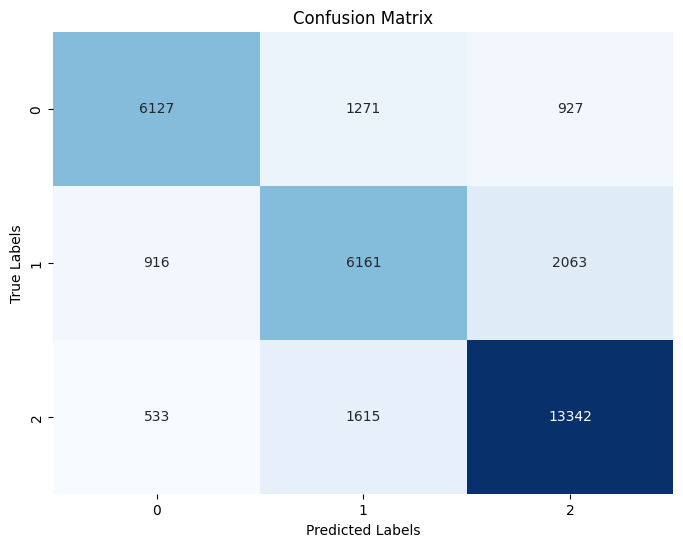

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
